# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# Set default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(3):                                         # play game for n episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        # print(actions)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        # sactions = np.expand_dims(np.array(actions).reshape(2, 2),0)
        # print(sactions.shape)
        # print(sactions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        # print(len(next_states))
        # print(len(next_states[0]))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(scores)
    
    print('Max score for the episode: {}'.format(round(episode_reward, 3)))

Max score for the episode: 0.0
Max score for the episode: 0.09
Max score for the episode: 0.0


When finished, you can close the environment.

In [ ]:
# env.close()

# Implemantation

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

FC1 = 64
FC2 = 64

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=FC1, fc2_units=FC2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=FC1, fc2_units=FC2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
        self.fcs1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
def flatten(tensor):
    return torch.reshape(tensor, (tensor.shape[0], -1,))

## Agent

In [24]:
import random
import copy
import os

from utils import OUNoise, ReplayBuffer
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

EPSILON = 1.0           # Noise decay start value
EPSILON_DECAY = 1e-6    # Noise decay factor
GRAD_CLIPPING = 1.0     # Gradient Clipping


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDPGAgent():
    """Interacts with and learns from the environment.
    2 actor networks - input is agents observation and output is action
    2 critic networks - inputs observations from all agents in Buffer. Outputs Q function of expected reward.
    Observations 24 dims, Actions 2 dims.
    """
    
    def __init__(self, state_size, action_size, num_agents, agent_index, random_seed, eval_mode=False):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            agent_index (int): index of agent
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON
        self.agent_index = agent_index

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, 
                                           weight_decay=WEIGHT_DECAY)
        
        # Init target weights
        # self._copy_weights(self.actor_local, self.actor_target)
        # self._copy_weights(self.critic_local, self.critic_target)
        self.learn_step = 0
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)


    def act(self, state, add_noise=True):
        """
        Returns actions for given state as per current policy.
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, agents, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #

        # Get predicted next-state actions and Q values from target models
        # actions_next = self.actor_target(next_states)
        # len(states) = batch_size
        next_actions  = torch.zeros((len(states), num_agents, self.action_size)).to(device)
        for i, agent in enumerate(agents):            
            next_actions[:, i] = agent.actor_target(states[:, i, :])
       
        # Compute Q targets for current states (y_i)
        Q_targets_next = self.critic_target(flatten(next_states), flatten(next_actions))
        agent_rewards = rewards[:, self.agent_index, :]
        agent_dones = dones[:, self.agent_index, :]
        Q_targets = agent_rewards + (gamma * Q_targets_next * (1 - agent_dones))
        
        # Compute local expected Q
        Q_expected = self.critic_local(flatten(states), flatten(actions))
        
        # MSE loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        if GRAD_CLIPPING:
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), GRAD_CLIPPING)
        # for param in self.critic_local.parameters():
        #    param.grad.data.clamp_(-1, 1)
        
        self.critic_optimizer.step()


        # ---------------------------- update actor ---------------------------- #
        
        # Actor only sees local state
        predicted_actions = torch.zeros((len(states), num_agents, self.action_size)).to(device)
        predicted_actions.data.copy_(actions.data)
        predicted_actions[:, self.agent_index] = self.actor_local(states[:, self.agent_index])
        
        # Compute actor loss
        actor_loss = -self.critic_local(flatten(states), flatten(predicted_actions)).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        if GRAD_CLIPPING:
            torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), GRAD_CLIPPING)
        self.actor_optimizer.step()

        # ----------------------- update target networks -------------------------- #
        
        # self.soft_update(self.critic_local, self.critic_target, TAU)
        # self.soft_update(self.actor_local, self.actor_target, TAU)

        if self.learn_step == 0:
            # One time only, start local and target with same parameters
            self._copy_weights(self.critic_local, self.critic_target)
            self._copy_weights(self.actor_local, self.actor_target)
        else:
            self.soft_update(self.critic_local, self.critic_target, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)
            
        self.learn_step += 1
        
        # --------------------- update epsilon decay ------------------------------ #
        
        if EPSILON_DECAY > 0:
            self.epsilon -= EPSILON_DECAY
            self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            
    def _copy_weights(self, source_network, target_network):
        """Copy source network weights to target"""
        for target_param, source_param in zip(target_network.parameters(), source_network.parameters()):
            target_param.data.copy_(source_param.data)
            
    def save_checkpoint(self):
        actor_filename = os.path.join(os.getcwd(), 'checkpoint_actor_{}.pth'.format(self.agent_index))
        critic_filename = os.path.join(os.getcwd(), 'checkpoint_critic_{}.pth'.format(self.agent_index))
        torch.save(self.actor_local.state_dict(), actor_filename)
        torch.save(self.critic_local.state_dict(), critic_filename)
        
    def load_checkpoint(self):
        actor_filename = os.path.join(os.getcwd(), 'checkpoint_actor_{}.pth'.format(self.agent_index))
        critic_filename = os.path.join(os.getcwd(), 'checkpoint_critic_{}.pth'.format(self.agent_index))
        self.actor_local.load_state_dict(torch.load(actor_filename, map_location='cpu'))
        self.critic_local.load_state_dict(torch.load(critic_filename, map_location='cpu'))
        self.actor_local.eval()                                
        

## MADDPG agents

In [21]:
class MADDPG_agents(object):
    '''
    The main class that defines and trains all the agents
    '''
    def __init__(self, state_size, action_size, num_agents, random_seed, eval_mode=False):
        
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        
        # AGENTS
        self.agents = [DDPGAgent(state_size, action_size, num_agents, agent_index=i, random_seed=random_seed) 
                       for i in range(self.num_agents)]
        
        # BUFFER
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, device)

    def act(self, states, add_noise=True):
        """Executes act on all the agents
        Parameters:
            states (list): list of states, one for each agent
            add_noise (bool): whether to apply noise to the actions
        """
        actions = []
        for i, agent in enumerate(self.agents):
            action = agent.act(states[i], add_noise)
            actions.append(action)
        return actions
            
    def step(self, states, actions, rewards, next_states, dones):
        """
        Save experience in replay memory, and Learn by sampling uniformly.
        """
        # SAVE IN BUFFER
        states = np.expand_dims(states, 0)
        actions = np.expand_dims(np.array(actions).reshape(self.num_agents, self.action_size),0)
        rewards = np.expand_dims(np.array(rewards).reshape(self.num_agents, -1),0)
        dones = np.expand_dims(np.array(dones).reshape(self.num_agents, -1),0)
        next_states = np.expand_dims(np.array(next_states).reshape(self.num_agents, -1),0)
        for _ in range(10):
            self.memory.add(states, actions, rewards, next_states, dones)
        
        # LEARN
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample() 
            for agent in self.agents:
                agent.learn(self.agents, experiences, GAMMA)

    def reset(self):
        for agent in self.agents:
            agent.reset()
                
    def save_checkpoint(self):
        for agent in self.agents:
            agent.save_checkpoint()
            
    def load_checkpoint(self):
        for agent in self.agents:
            agent.load_checkpoint()

## MADDPG Trainer

In [15]:
from itertools import count

def maddpg_trainer(n_episodes=2000, print_every=100):
    scores_deque = deque(maxlen=100)
    scores_global = []
    moving_avgs = []

    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment 
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        maddpg_agent.reset()
        score_average = 0

        for t in count():

            actions = maddpg_agent.act(states)                 # get actions           
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            # MADDPG step
            maddpg_agent.step(states, actions, rewards, next_states, dones)

            states = next_states                               # roll over states to next time step
            scores += env_info.rewards                         # update the score (for each agent) 
            if np.any(dones):                                  # exit loop if episode finished
                break

        # Max score
        score = np.max(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        moving_avgs.append(score_average)

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_average))
        elif score_average >= 0.5:
            print('\rEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))
            maddpg_agent.save_checkpoint()
            break
        else:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_average), end="")
        
    return scores_global, moving_avgs

## Train

In [27]:
import time
t0 = time.time()

# Init Agent
maddpg_agent = MADDPG_agents(state_size=state_size, action_size=action_size, random_seed=111, num_agents=num_agents)

# Train
n_episodes = 1500
scores, avgs = maddpg_trainer(n_episodes = n_episodes)

print('\nRuntime {} mins'.format(round((time.time() - t0)/60, 1)))

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.04
Episode 400	Average Score: 0.05
Episode 500	Average Score: 0.07
Episode 600	Average Score: 0.09
Episode 700	Average Score: 0.10
Episode 800	Average Score: 0.13
Episode 900	Average Score: 0.17
Episode 1000	Average Score: 0.45
Environment solved in 1004 episodes!	Average Score: 0.50

Runtime 27.6 mins


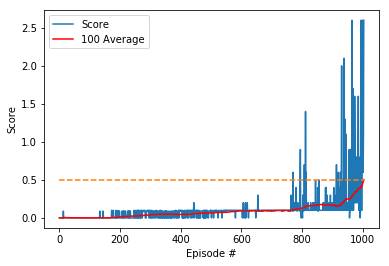

In [28]:
import matplotlib.pyplot as plt

horiz_line = np.array([0.5 for i in range(len(scores))])

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores)), avgs, c='r', label='100 Average')
plt.plot(np.arange(len(scores)), horiz_line, '--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

## Test Smart Agent

In [15]:
# Init Agents
maddpg_agent = MADDPG_agents(state_size=state_size, action_size=action_size, random_seed=0, num_agents=num_agents)

# Load the weights from file
maddpg_agent.load_checkpoint()

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = maddpg_agent.act(states, add_noise=False)# get actions  
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    # Calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(scores)
    print('Max score for the episode: {}'.format(round(episode_reward, 3)))

Max score for the episode: 0.3
Max score for the episode: 2.5
Max score for the episode: 0.3
Max score for the episode: 0.19
Max score for the episode: 0.2
